## Xランキングのブキ使用率

In [1]:
import base64
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v
import packages.splatnet as splatnet

lobby = d.Lobby.XMATCH

request_id = base64.b64encode("XRankingSeason-p:4".encode()).decode()
modes = [
    { "key": "area", "code": "Ar", "hash": "eb69df6f2a2f13ab207eedc568f0f8b6" },
    { "key": "yagura", "code": "Lf", "hash": "4e8b381ae6f9620443627f4eac3a2210" },
    { "key": "hoko", "code": "Gl", "hash": "5f8f333770ed3c43e21b0121f3a86716" },
    { "key": "asari", "code": "Cl", "hash": "68f99b7b02537bcb881db07e4e67f8dd" },
]

tz = dt.timezone(dt.timedelta(hours=9))
today = dt.datetime.now(tz).date()
today

datetime.date(2023, 7, 2)

In [2]:
player_list = []
for mode in modes:
    mode_key = mode["key"]
    mode_code = mode["code"]
    mode_hash = mode["hash"]
    for i in range(5):
        print(mode_key, f"{(i + 1)}/5")
        result = splatnet.fetch({
            "variables": {
                "id": request_id,
                "first": 100,
                "page": i + 1,
            },
            "extensions": {
                "persistedQuery": {
                    "version": 1,
                    "sha256Hash": mode_hash,
                }
            },
        })
        edges = result["data"]["node"][f"xRanking{mode_code}"]["edges"]
        player_list += list(map(lambda x: {
            "mode": mode_key,
            "name": x["node"]["name"],
            "rank": x["node"]["rank"],
            "power": x["node"]["xPower"],
            "weapon": x["node"]["weapon"]["name"],
        }, edges))


area 1/5
area 2/5
area 3/5
area 4/5
area 5/5
yagura 1/5
yagura 2/5
yagura 3/5
yagura 4/5
yagura 5/5
hoko 1/5
hoko 2/5
hoko 3/5
hoko 4/5
hoko 5/5
asari 1/5
asari 2/5
asari 3/5
asari 4/5
asari 5/5


In [3]:
locale = Locale.JA

In [4]:
from packages.master import load_master, Master

main = load_master(Master.MAIN_WEAPON)
key_name = main[["name-ja"]].to_dict()["name-ja"]
name_key = {v:k for k, v in key_name.items()}

players = pd.DataFrame(player_list)
players["weapon"] = players["weapon"].map(name_key).replace("heroshooter_replica", "sshooter")
players["sub-weapon"] = players["weapon"].map(main[["sub-key"]].to_dict()["sub-key"])
players["special-weapon"] = players["weapon"].map(main[["special-key"]].to_dict()["special-key"])
players


,mode,name,rank,power,weapon,sub-weapon,special-weapon
0,area,ばりあせいじん,1,3137.5,wakaba,splashbomb,greatbarrier
1,area,Soda,2,3036.2,bucketslosher,splashbomb,tripletornado
2,area,なえぺろマンTV,3,3036.1,barrelspinner_deco,pointsensor,teioika
3,area,ストロベリーのりたん,4,3034.8,jimuwiper,quickbomb,shokuwander
4,area,とーぞく_コンたん,5,3017.5,bottlegeyser,splashshield,ultrashot
...,...,...,...,...,...,...,...
1995,asari,しょうりきてんほう,496,2679.7,bucketslosher,splashbomb,tripletornado
1996,asari,いつか,497,2678.7,campingshelter_sorella,trap,ultrashot
1997,asari,みけむら,498,2678.7,momiji,torpedo,hopsonar
1998,asari,lenomi,499,2678.6,kugelschreiber,tansanbomb,jetpack


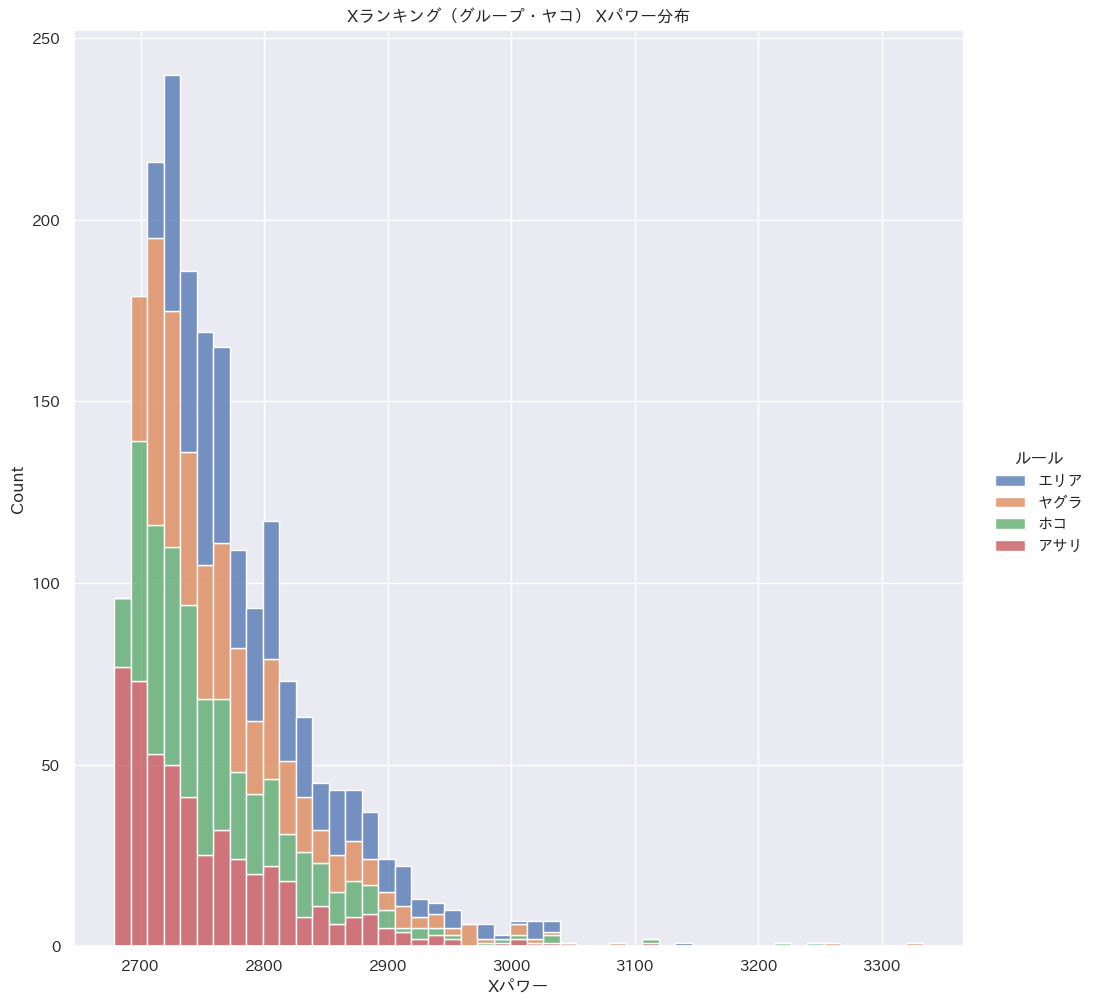

In [5]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "Xランキング（グループ・ヤコ） Xパワー分布", "X Power distribution in X Rankings (Takoroka)")
i18n.add("power", "Xパワー", "X Power")
i18n.add("mode", "ルール", "Mode")

g = sns.displot(
    data=players,
    x="power",
    hue="mode",
    hue_order=d.MODE_ORDER,
    multiple="stack",
    height=10,
)
ax = g.ax

ax.set(
    title=i18n.t("title"),
    xlabel=i18n.t("power"),
)

legend = g.fig.legends[0]
legend.set(title=i18n.t("mode"))
for i, mode in enumerate(d.MODE_ORDER):
    legend.texts[i].set_text(i18n.t(mode))

plt.show()

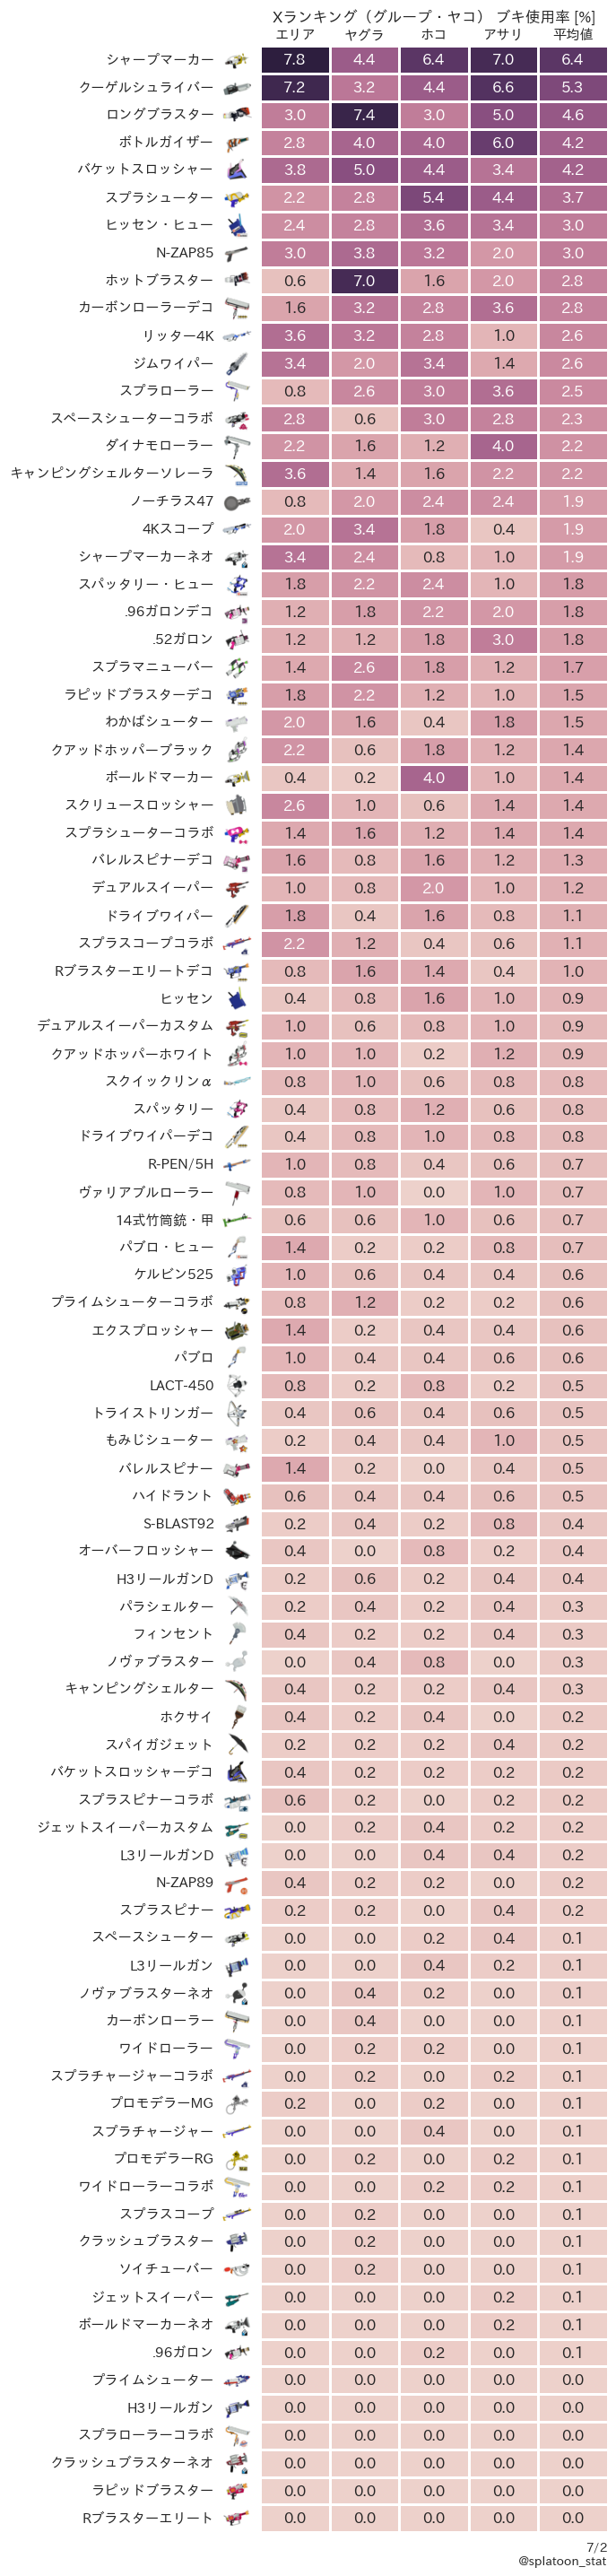

In [6]:
usage = players.groupby("mode")["weapon"].value_counts(normalize=True).to_frame("usage")
usage_map = usage.reset_index().pivot(index="weapon", columns="mode", values="usage").reindex(d.MODE_ORDER, axis=1).fillna(0)
usage_map["mean"] = usage_map.mean(axis=1)
usage_map = usage_map.sort_values("mean", ascending=False)

used_weapons = usage_map.index.to_list()
unused_weapons = [x for x in d.WEAPON_ORDER if not x in used_weapons]
unused_usage_map = pd.DataFrame([
    {"weapon": x, "area": 0, "yagura": 0, "hoko": 0, "asari": 0, "mean": 0}
    for x in unused_weapons
]).set_index("weapon")

usage_map = pd.concat([usage_map, unused_usage_map])


sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "Xランキング（グループ・ヤコ） ブキ使用率 [%]", "Weapon usage in X Rankings (Takoroka) [%]")

fig, ax = plt.subplots(figsize=(5, len(usage_map.index) * 0.4))
sns.heatmap(
    data=usage_map.mul(100),
    annot=True,
    fmt=".1f",
    cbar=False,
    cmap=sns.cubehelix_palette(gamma=1.0, as_cmap=True),
    linewidths=2,
    ax=ax,
)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(length=0)

xkeys, ykeys = u.get_ax_ticklabels(ax)
xticklabels = [i18n.t(x) for x in xkeys]
yticklabels = [i18n.t(x) for x in ykeys]

ax.set(
    title=i18n.t("title"),
    xlabel="",
    ylabel="",
    xticklabels=xticklabels,
)
ax.yaxis.set_ticklabels(yticklabels, x=-0.12)

for i, key in enumerate(ykeys):
    image_path = image.get_image_path(key)
    img = OffsetImage(plt.imread(image_path), zoom=.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (0, 0), xybox=(-0.33, i + 0.5), frameon=False)
    ax.add_artist(ab)

u.credit(ax, fig, i18n.t_date(today), 0.3)

plt.show()

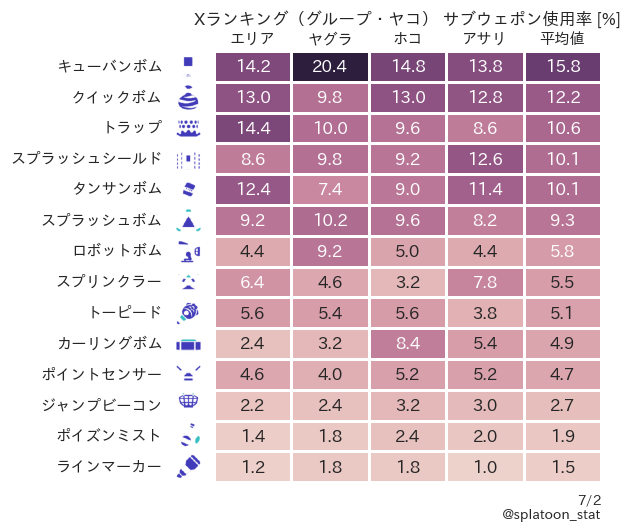

In [7]:
usage = players.groupby("mode")["sub-weapon"].value_counts(normalize=True).to_frame("usage")
usage_map = usage.reset_index().pivot(index="sub-weapon", columns="mode", values="usage").reindex(d.MODE_ORDER, axis=1)
usage_map["mean"] = usage_map.fillna(0).mean(axis=1)
usage_map = usage_map.sort_values("mean", ascending=False)

sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "Xランキング（グループ・ヤコ） サブウェポン使用率 [%]", "Sub weapon usage in X Rankings (Takoroka) [%]")

fig, ax = plt.subplots(figsize=(5, len(usage_map.index) * 0.4))
sns.heatmap(
    data=usage_map.mul(100),
    annot=True,
    fmt=".1f",
    cbar=False,
    cmap=sns.cubehelix_palette(gamma=1.0, as_cmap=True),
    linewidths=2,
    ax=ax,
)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(length=0)

xkeys, ykeys = u.get_ax_ticklabels(ax)
xticklabels = [i18n.t(x) for x in xkeys]
yticklabels = [i18n.t(x) for x in ykeys]

ax.set(
    title=i18n.t("title"),
    xlabel="",
    ylabel="",
    xticklabels=xticklabels,
)
ax.yaxis.set_ticklabels(yticklabels, x=-0.12)

for i, key in enumerate(ykeys):
    image_path = image.get_image_path(key)
    img = OffsetImage(plt.imread(image_path), zoom=.5)
    img.image.axes = ax
    ab = AnnotationBbox(img, (0, 0), xybox=(-0.33, i + 0.5), frameon=False)
    ax.add_artist(ab)

u.credit(ax, fig, i18n.t_date(today), 0.3)

plt.show()

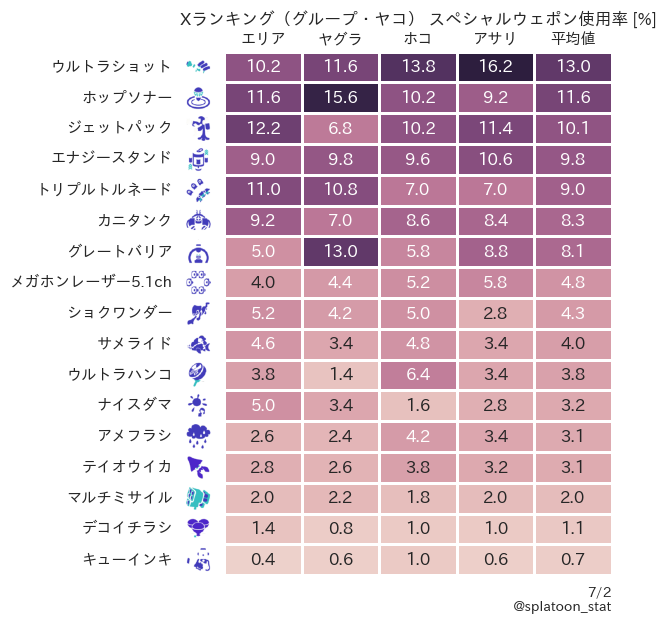

In [8]:
usage = players.groupby("mode")["special-weapon"].value_counts(normalize=True).to_frame("usage")
usage_map = usage.reset_index().pivot(index="special-weapon", columns="mode", values="usage").reindex(d.MODE_ORDER, axis=1)
usage_map["mean"] = usage_map.fillna(0).mean(axis=1)
usage_map = usage_map.sort_values("mean", ascending=False)

sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "Xランキング（グループ・ヤコ） スペシャルウェポン使用率 [%]", "Special weapon usage in X Rankings (Takoroka) [%]")

fig, ax = plt.subplots(figsize=(5, len(usage_map.index) * 0.4))
sns.heatmap(
    data=usage_map.mul(100),
    annot=True,
    fmt=".1f",
    cbar=False,
    cmap=sns.cubehelix_palette(gamma=1.0, as_cmap=True),
    linewidths=2,
    ax=ax,
)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(length=0)

xkeys, ykeys = u.get_ax_ticklabels(ax)
xticklabels = [i18n.t(x) for x in xkeys]
yticklabels = [i18n.t(x) for x in ykeys]

ax.set(
    title=i18n.t("title"),
    xlabel="",
    ylabel="",
    xticklabels=xticklabels,
)
ax.yaxis.set_ticklabels(yticklabels, x=-0.12)

for i, key in enumerate(ykeys):
    image_path = image.get_image_path(key)
    img = OffsetImage(plt.imread(image_path), zoom=.5)
    img.image.axes = ax
    ab = AnnotationBbox(img, (0, 0), xybox=(-0.33, i + 0.5), frameon=False)
    ax.add_artist(ab)

u.credit(ax, fig, i18n.t_date(today), 0.3)

plt.show()